In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [6]:
pd.set_option('display.max_rows', 300)

## BW #12: Tourism

The numbers come from the International Trade Administration, part of the US Commerce Department. They keep track of many trade-related numbers, and since tourism is a major part of US trade, they keep track of tourists, too. Their “arrivals program” has been tracking the number and origin of tourists every month for more than 20 years, as described here: https://www.trade.gov/i-94-arrivals-program

### Data

This week, we're going to look at monthly arrivals by plane from outside of the United States. I'm warning you now that we're going to be working hard to clean this data up, in order to analyze it. It might appear at first as though the data is nice and tidy, **but bringing it into Pandas will be a bit painful**.

The data is in a single Excel spreadsheet, containing monthly arrivals by airplane into the US starting in the year 2000. You can get it from:

https://www.trade.gov/sites/default/files/2022-02/Monthly-Arrivals-2000-Present.xlsx

### Tasks

We'll start by taking this file and turning it into two data frames:

1. In the smaller data frame (countries_df), there are only two columns. The index contains country names, and the one non-index data column (region) comes from Excel's column B. You'll have to ignore a bunch of blank/empty rows in the Excel spreadsheet.
2. In the larger data frame (travel_df), there are many columns, once for each monthly report. Make the index the same as in countries_df, with country names from Excel's column B. The other columns will all be datetime values, with a year and month. (The day doesn’t matter, and the time will always be midnight.)

As promised, there will be some cleaning to do to create travel_df:

1. The final columns in the file have the word “Preliminary”; that word should be stripped.
2. All column names/headers should be turned into datetime objects. Remove any columns whose names that cannot be turned into datetimes.
3. In the data, replace any instances of ' - ' (i.e., a string containing one space, a minus sign, and three spaces with 0.
4. In the data, replace NaN with 0.
5. Set the dtype of all columns to int.

Note: For reasons I still don't understand, the dates in our columns are being interpreted by Pandas as being of a certain year and month (as written), and then with increasing days, starting with 1. So column 20 will be listed as the 20th of the month, and column 30 will be listed as being on the 30th of the month. This shouldn't affect things.

Now let's ask some more general questions:
 
3. In the most recent report, which 10 countries had the greatest number of tourists enter the US?
4. In the first report, which 10 countries had the greatest number of tourists enter the US?
5. Total the number of tourists from each region in the earliest report vs. the latest report. (Yes, you could get this directly from the original Excel spreadsheet, but I want you to calculate this yourself!) Do we see any changes in the last two decades or so?
6. Have any countries had more month-to-month declines in tourism to the US than increases?
7. Calculate the mean of tourists from each country for each decade. (And yes, the current decade will be listed as December 31st, 2030.)

This week’s learning goals include a lot of cleaning (including renaming columns), joins, grouping, time series, resampling, and working with different axes.


In [2]:
data = "./data/Monthly-Arrivals-2000-Present.xlsx"

#### 1. Create countries_df: The index contains country names, and the one non-index data column (region) comes from Excel's column B. Ignore blank/empty rows.

In [9]:
pd.read_excel(data).iloc[19:].head(5)

,1,International Visitors--\n 1) Country of Residence\n 2) 1+ nights in the USA\n 3) Among qualified visa types,World \nRegion,2000-01-02 00:00:00,2000-02-03 00:00:00,2000-03-06 00:00:00,2000-04-07 00:00:00,2000-05-09 00:00:00,2000-06-10 00:00:00,2000-07-12 00:00:00,...,2022-12,2023-01,2023-02,2023-03\nPreliminary,Unnamed: 282,Unnamed: 283,Unnamed: 284,Unnamed: 285,Notes:,
19,21.0,Afghanistan,Asia,3.0,10.0,7.0,8.0,15.0,9.0,11.0,...,402.0,265.0,234.0,293.0,NaN,NaN,NaN,NaN,NaN,
20,22.0,Albania,Eastern Europe,200.0,214.0,240.0,336.0,483.0,422.0,443.0,...,2441.0,1507.0,1236.0,2080.0,NaN,NaN,NaN,NaN,NaN,
21,23.0,Algeria,Africa,234.0,176.0,222.0,347.0,261.0,324.0,349.0,...,1108.0,747.0,703.0,890.0,NaN,NaN,NaN,NaN,NaN,
22,24.0,Andorra,Western Europe,110.0,59.0,102.0,119.0,119.0,91.0,116.0,...,164.0,139.0,178.0,200.0,NaN,NaN,NaN,NaN,NaN,
23,25.0,Angola,Africa,333.0,180.0,183.0,249.0,253.0,228.0,291.0,...,575.0,360.0,244.0,330.0,NaN,NaN,NaN,NaN,NaN,


In [18]:
df_countries = pd.read_excel(
    data,
    skiprows=20,
    header=None,
    usecols=[1, 2],
    names=["country", "region"],
    index_col=0,
).dropna()
df_countries.head()

,region
country,
Afghanistan,Asia
Albania,Eastern Europe
Algeria,Africa
Andorra,Western Europe
Angola,Africa


#### 2. Create travel_df, with many columns, one for each monthly report. Make the index the same as in countries_df, with country names from Excel's column B. The other columns will all be datetime values, with a year and month.


In [24]:
# does not work, we loose the header
pd.read_excel(
    data,
    skiprows=20,
    header=None,
    index_col=0,
).head()

,1,2,3,4,5,6,7,8,9,10,...,278,279,280,281,282,283,284,285,286,287
0,,,,,,,,,,,,,,,,,,,,,
21.0,Afghanistan,Asia,3.0,10.0,7.0,8.0,15.0,9.0,11.0,20.0,...,402.0,265.0,234.0,293.0,NaN,NaN,NaN,NaN,NaN,
22.0,Albania,Eastern Europe,200.0,214.0,240.0,336.0,483.0,422.0,443.0,549.0,...,2441.0,1507.0,1236.0,2080.0,NaN,NaN,NaN,NaN,NaN,
23.0,Algeria,Africa,234.0,176.0,222.0,347.0,261.0,324.0,349.0,310.0,...,1108.0,747.0,703.0,890.0,NaN,NaN,NaN,NaN,NaN,
24.0,Andorra,Western Europe,110.0,59.0,102.0,119.0,119.0,91.0,116.0,117.0,...,164.0,139.0,178.0,200.0,NaN,NaN,NaN,NaN,NaN,
25.0,Angola,Africa,333.0,180.0,183.0,249.0,253.0,228.0,291.0,321.0,...,575.0,360.0,244.0,330.0,NaN,NaN,NaN,NaN,NaN,


In [64]:
df_travel = pd.read_excel(data).drop(range(0, 19)).drop(
    [1, "World \nRegion", " ", "Notes:"], axis="columns"
)
df_travel.head()

,International Visitors--\n 1) Country of Residence\n 2) 1+ nights in the USA\n 3) Among qualified visa types,2000-01-02 00:00:00,2000-02-03 00:00:00,2000-03-06 00:00:00,2000-04-07 00:00:00,2000-05-09 00:00:00,2000-06-10 00:00:00,2000-07-12 00:00:00,2000-08-13 00:00:00,2000-09-14 00:00:00,...,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03\nPreliminary,Unnamed: 282,Unnamed: 283,Unnamed: 284,Unnamed: 285
19,Afghanistan,3.0,10.0,7.0,8.0,15.0,9.0,11.0,20.0,19.0,...,327.0,244.0,402.0,265.0,234.0,293.0,NaN,NaN,NaN,NaN
20,Albania,200.0,214.0,240.0,336.0,483.0,422.0,443.0,549.0,612.0,...,1404.0,1561.0,2441.0,1507.0,1236.0,2080.0,NaN,NaN,NaN,NaN
21,Algeria,234.0,176.0,222.0,347.0,261.0,324.0,349.0,310.0,360.0,...,836.0,739.0,1108.0,747.0,703.0,890.0,NaN,NaN,NaN,NaN
22,Andorra,110.0,59.0,102.0,119.0,119.0,91.0,116.0,117.0,79.0,...,223.0,139.0,164.0,139.0,178.0,200.0,NaN,NaN,NaN,NaN
23,Angola,333.0,180.0,183.0,249.0,253.0,228.0,291.0,321.0,263.0,...,307.0,251.0,575.0,360.0,244.0,330.0,NaN,NaN,NaN,NaN


In [65]:
cols = df_travel.columns.to_list()
cols[0] = "country"
df_travel.columns = cols
df_travel.set_index("country", inplace=True)
df_travel.head()

,2000-01-02 00:00:00,2000-02-03 00:00:00,2000-03-06 00:00:00,2000-04-07 00:00:00,2000-05-09 00:00:00,2000-06-10 00:00:00,2000-07-12 00:00:00,2000-08-13 00:00:00,2000-09-14 00:00:00,2000-10-16 00:00:00,...,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03\nPreliminary,Unnamed: 282,Unnamed: 283,Unnamed: 284,Unnamed: 285
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,3.0,10.0,7.0,8.0,15.0,9.0,11.0,20.0,19.0,14.0,...,327.0,244.0,402.0,265.0,234.0,293.0,NaN,NaN,NaN,NaN
Albania,200.0,214.0,240.0,336.0,483.0,422.0,443.0,549.0,612.0,768.0,...,1404.0,1561.0,2441.0,1507.0,1236.0,2080.0,NaN,NaN,NaN,NaN
Algeria,234.0,176.0,222.0,347.0,261.0,324.0,349.0,310.0,360.0,334.0,...,836.0,739.0,1108.0,747.0,703.0,890.0,NaN,NaN,NaN,NaN
Andorra,110.0,59.0,102.0,119.0,119.0,91.0,116.0,117.0,79.0,134.0,...,223.0,139.0,164.0,139.0,178.0,200.0,NaN,NaN,NaN,NaN
Angola,333.0,180.0,183.0,249.0,253.0,228.0,291.0,321.0,263.0,256.0,...,307.0,251.0,575.0,360.0,244.0,330.0,NaN,NaN,NaN,NaN


In [69]:
df_travel = df_travel.dropna(how="all")

In [70]:
df_travel = df_travel.iloc[:,:-4] # or use drop with a list comprehension filtering the unnamed columns

##### The final columns in the file have the word “Preliminary”; that word should be stripped.

In [74]:
df_travel.rename(columns={col: col.removesuffix("Preliminary").strip() for col in df_travel.columns if str(col).endswith("Preliminary")}, inplace=True)
df_travel.head()

,2000-01-02 00:00:00,2000-02-03 00:00:00,2000-03-06 00:00:00,2000-04-07 00:00:00,2000-05-09 00:00:00,2000-06-10 00:00:00,2000-07-12 00:00:00,2000-08-13 00:00:00,2000-09-14 00:00:00,2000-10-16 00:00:00,...,2022-6,2022-7,2022-8,2022-9,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,3.0,10.0,7.0,8.0,15.0,9.0,11.0,20.0,19.0,14.0,...,317.0,370.0,379.0,274.0,327.0,244.0,402.0,265.0,234.0,293.0
Albania,200.0,214.0,240.0,336.0,483.0,422.0,443.0,549.0,612.0,768.0,...,1489.0,1177.0,1247.0,1570.0,1404.0,1561.0,2441.0,1507.0,1236.0,2080.0
Algeria,234.0,176.0,222.0,347.0,261.0,324.0,349.0,310.0,360.0,334.0,...,608.0,895.0,870.0,1034.0,836.0,739.0,1108.0,747.0,703.0,890.0
Andorra,110.0,59.0,102.0,119.0,119.0,91.0,116.0,117.0,79.0,134.0,...,161.0,237.0,276.0,165.0,223.0,139.0,164.0,139.0,178.0,200.0
Angola,333.0,180.0,183.0,249.0,253.0,228.0,291.0,321.0,263.0,256.0,...,270.0,366.0,468.0,314.0,307.0,251.0,575.0,360.0,244.0,330.0


##### All column names/headers should be turned into datetime objects. Remove any columns whose names that cannot be turned into datetimes.

In [83]:
df_travel.rename({x: pd.to_datetime(x, format="%Y-%m") for x in df_travel.columns if isinstance(x, str)}, axis="columns", inplace=True)

In [85]:
df_travel.columns

DatetimeIndex(['2000-01-02', '2000-02-03', '2000-03-06', '2000-04-07',
               '2000-05-09', '2000-06-10', '2000-07-12', '2000-08-13',
               '2000-09-14', '2000-10-16',
               ...
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', length=279, freq=None)

##### In the data, replace any instances of ' - ' (i.e., a string containing one space, a minus sign, and three spaces with 0.

In [96]:
df_travel.loc[(df_travel == ' -   ').any(axis=1), (df_travel == ' -   ').any()]

,2007-12-01,2010-09-01
country,,
Christmas Island,-,1
Cocos Islands,4,-
Falkland Islands,-,-
Holy See/Vatican,-,5
Niue,-,1
Pitcairn Islands,-,0
Tuvalu,-,2
Wallis And Futuna Islands,10,-
Western Sahara,1,-


In [98]:
df_travel.replace(" -   ", 0, inplace=True)

##### In the data, replace NaN with 0.

In [100]:
df_travel = df_travel.fillna(0)

##### Set the dtype of all columns to int.

In [105]:
df_travel.head()

,2000-01-02,2000-02-03,2000-03-06,2000-04-07,2000-05-09,2000-06-10,2000-07-12,2000-08-13,2000-09-14,2000-10-16,...,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,3.0,10.0,7.0,8.0,15.0,9.0,11.0,20.0,19.0,14.0,...,317.0,370.0,379.0,274.0,327.0,244.0,402.0,265.0,234.0,293.0
Albania,200.0,214.0,240.0,336.0,483.0,422.0,443.0,549.0,612.0,768.0,...,1489.0,1177.0,1247.0,1570.0,1404.0,1561.0,2441.0,1507.0,1236.0,2080.0
Algeria,234.0,176.0,222.0,347.0,261.0,324.0,349.0,310.0,360.0,334.0,...,608.0,895.0,870.0,1034.0,836.0,739.0,1108.0,747.0,703.0,890.0
Andorra,110.0,59.0,102.0,119.0,119.0,91.0,116.0,117.0,79.0,134.0,...,161.0,237.0,276.0,165.0,223.0,139.0,164.0,139.0,178.0,200.0
Angola,333.0,180.0,183.0,249.0,253.0,228.0,291.0,321.0,263.0,256.0,...,270.0,366.0,468.0,314.0,307.0,251.0,575.0,360.0,244.0,330.0


In [103]:
df_travel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233 entries, Afghanistan to Zimbabwe
Columns: 279 entries, 2000-01-02 to 2023-03-01
dtypes: float64(279)
memory usage: 517.8+ KB


In [106]:
df_travel = df_travel.astype(int)

#### 3. In the most recent report, which 10 countries had the greatest number of tourists enter the US?

In [112]:
df_travel["2023-03-01"].sort_values(ascending=False).head(10)

country
United Kingdom    300896
Germany           144399
Japan             112269
South Korea       106087
India             105203
Brazil            103830
France             92747
China              67440
Italy              62312
Colombia           61949
Name: 2023-03-01 00:00:00, dtype: int64

In [113]:
df_travel.iloc[:, -1].sort_values(ascending=False).head(10)

country
United Kingdom    300896
Germany           144399
Japan             112269
South Korea       106087
India             105203
Brazil            103830
France             92747
China              67440
Italy              62312
Colombia           61949
Name: 2023-03-01 00:00:00, dtype: int64

#### 4. In the first report, which 10 countries had the greatest number of tourists enter the US?

In [114]:
df_travel.iloc[:, 0].sort_values(ascending=False).head(10)

country
Canada            937669
Japan             354266
United Kingdom    242422
Mexico            234000
Germany           100632
Brazil             69634
France             63624
Argentina          54136
South Korea        53797
Italy              41661
Name: 2000-01-02 00:00:00, dtype: int64

#### 5. Total the number of tourists from each region in the earliest report vs. the latest report. Do we see any changes in the last two decades or so?

In [129]:
(
    df_travel
    .join(df_countries)
    .groupby("region")[[df_travel.columns[0], df_travel.columns[-1]]]
    .sum()
).round(0).pct_change(axis=1).sort_values(df_travel.columns[-1], ascending=False)

,2000-01-02 00:00:00,2023-03-01 00:00:00
region,,
Eastern Europe,NaN,1.161407
Africa,NaN,0.736536
Central America,NaN,0.466406
Western Europe,NaN,0.420322
Caribbean,NaN,0.412103
Middle East,NaN,0.393832
South America,NaN,0.382099
Oceania,NaN,0.367505
Asia,NaN,-0.076750


#### 6. Have any countries had more month-to-month declines in tourism to the US than increases?

In [158]:
(
    (df_travel.pct_change(axis=1) < 0).sum(axis=1) / 
    df_travel.shape[1] > 0.5
).loc[lambda x: x].index

Index(['Austria', 'Belarus', 'Bosnia and Herzegovina', 'Botswana', 'Brunei',
       'Canada', 'Colombia', 'Congo', 'Ethiopia', 'France', 'French Polynesia',
       'Hungary', 'Israel', 'Malawi', 'Malaysia', 'Mozambique', 'Norway',
       'Pakistan', 'Papua New Guinea', 'Poland', 'Slovakia', 'Sudan',
       'Suriname', 'Swaziland', 'Taiwan', 'Thailand', 'Tunisia', 'Uganda',
       'Zaire ( formerly Congo, Democratic Republic of)'],
      dtype='object', name='country')

#### 7. Calculate the mean of tourists from each country for each decade. (And yes, the current decade will be listed as December 31st, 2030.)

In [161]:
df_travel.resample('10Y', axis="columns").mean().loc["Germany"]

/var/folders/x_/pp_bgvrn2qn_kh8n569y1gch0000gn/T/ipykernel_42470/302384637.py:1: FutureWarning: DataFrame.resample with axis=1 is deprecated. Do `frame.T.resample(...)` without axis instead.
  df_travel.resample('10Y', axis="columns").mean().loc["Germany"]


2000-12-31    148837.083333
2010-12-31    121035.383333
2020-12-31    155938.775000
2030-12-31     75858.000000
Freq: 10A-DEC, Name: Germany, dtype: float64

#### Bonus

<Axes: >

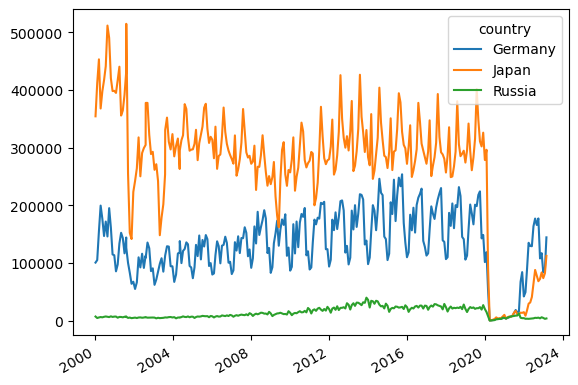

In [170]:
df_travel.loc[["Germany", "Japan", "Russia"]].T.plot()

<Axes: >

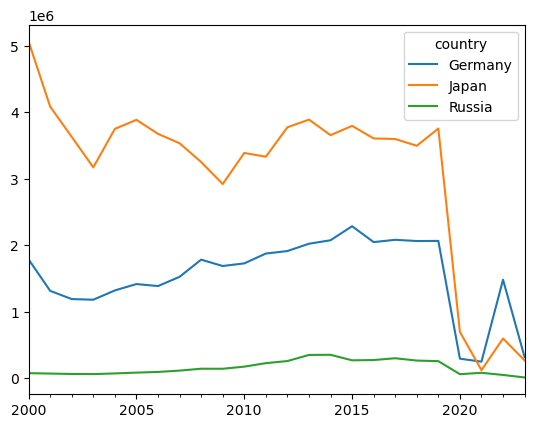

In [173]:
df_travel.loc[["Germany", "Japan", "Russia"]].T.resample("Y").sum().plot()